In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [2]:
prtest = np.array(pickle.load(open('/Users/harrylinehan-hill/Documents/Programming/porous_rock_images_test.pkl', 'rb')))
ftest = np.array(pickle.load(open('/Users/harrylinehan-hill/Documents/Programming/flux_test.pkl', 'rb')))
ft = np.array(pickle.load(open('/Users/harrylinehan-hill/Documents/Programming/flux_train.pkl', 'rb')))
prt = np.array(pickle.load(open('/Users/harrylinehan-hill/Documents/Programming/porous_rock_images_train.pkl', 'rb')))
ntest, ytest, xtest = prtest.shape
nt=ntest
yt=ytest
xt=xtest
n, y, x = prt.shape


In [3]:
# normalised mean square error - normalise, then mean square error s = simulated, o = observed
def nmse(s, o):
    s = np.array(s)
    o = np.array(o)
    mean = o.mean()
    std = o.std()
    onorm = (o - mean)/std
    snorm = (s - mean)/std
    return np.dot(onorm-snorm,onorm-snorm)

# r squared
def rsq(s, o):
    s = np.array(s)
    o = np.array(o)
    mean = o.mean()
    ssres = np.dot(s - o, s - o)
    sstot = np.dot(o-mean,o-mean)
    return 1 - ssres/sstot




In [4]:
from gtda.homology import CubicalPersistence
CR = CubicalPersistence(n_jobs=-1)
PtCloudPers1 = CR.fit_transform(prt)
CR.plot(PtCloudPers1,0)


In [ ]:
#average of 10
#PtCloudPersvect10 = list()
#PtCloudPersvect10test = list()
#for g in range(10):
#    #train set
#    randummy = np.random.default_rng().uniform(size = (n,y,x))
#    flipsdummy = prt < randummy
#    xypts1dummy = list()
#    for m in range(n):
#        ptsdummy = np.argwhere(flipsdummy[m] == False)
#        xypts1dummy.append(ptsdummy)
#    PtCloudPersdummy = VR.fit_transform(xypts1dummy)
#    PtCloudPersvect10.append(PtCloudPersdummy)
#    #test set
#    randummy = np.random.default_rng().uniform(size = (ntest,ytest,xtest))
#    flipsdummy = prtest < randummy
#    xypts1dummy = list()
#    for m in range(n):
#        ptsdummy = np.argwhere(flipsdummy[m] == False)
#        xypts1dummy.append(ptsdummy)
#    PtCloudPerstestdummy = VR.fit_transform(xypts1dummy)
#    PtCloudPersvect10test.append(PtCloudPerstestdummy)

In [6]:
PtCloudPers1test = CR.fit_transform(prtest)
CR.plot(PtCloudPers1test,0)

In [7]:
# naive approach --- the mean
import numpy.polynomial.polynomial as npl
i = PtCloudPers1.shape[0]
mean = ft.mean()
meanvct = np.ones(n)*mean
meanvctest = np.ones(ntest)*mean

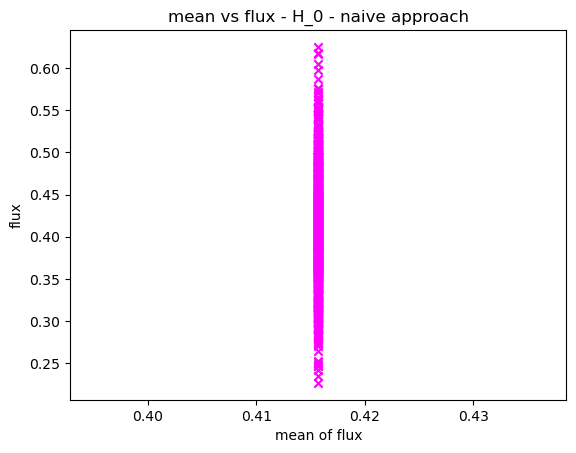

In [8]:
_ = plt.scatter(meanvct,ft, marker='x',color='magenta')
_ = plt.title('mean vs flux - H_0 - naive approach')
_ = plt.xlabel('mean of flux')
_ = plt.ylabel('flux')

plt.show()

In [9]:
#nmse and r^2 for the naive approach
print('nmse = ', nmse(meanvctest, ftest))
print('rsq = ', rsq(meanvctest,ftest))


nmse =  200.27057346569708
rsq =  -0.0013528673284854964


In [10]:
# sum(p-q) vs flux flip
import numpy.polynomial.polynomial as npl
i = PtCloudPers1.shape[0]
pers1diff_sum_0 = np.zeros(i)
for j in range(i): 
    C = PtCloudPers1[j,:,:]
    CH = C[np.where( C[:,2]== 0,)] 
    diff_vectC = CH[:,1] - CH[:,0]
    diff_sumC = np.sum(diff_vectC)
    pers1diff_sum_0[j] = diff_sumC

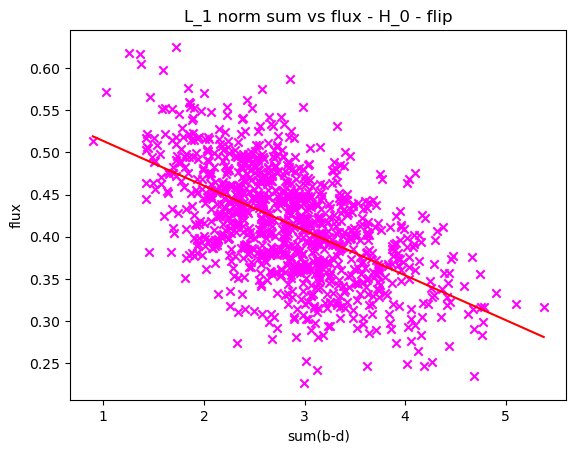

In [11]:
_ = plt.scatter(pers1diff_sum_0,ft, marker='x',color='magenta')
_ = plt.title('L_1 norm sum vs flux - H_0 - flip')
_ = plt.xlabel('sum(b-d)')
_ = plt.ylabel('flux')

#linear regression using polynomial fit
c, m  = npl.polyfit(pers1diff_sum_0, ft, 1)
r = [min(pers1diff_sum_0),max(pers1diff_sum_0)]
_ = plt.plot([min(pers1diff_sum_0),max(pers1diff_sum_0)], np.array(m) * r + c, 'r')
plt.show()

In [12]:
# sum(p-q) vs flux flip -- test
itest = PtCloudPers1test.shape[0]
pers1diff_sum_0test = np.zeros(itest)
for j in range(itest): 
    C = PtCloudPers1test[j,:,:]
    CH = C[np.where( C[:,2]== 0,)] 
    diff_vectC = CH[:,1] - CH[:,0]
    diff_sumC = np.sum(diff_vectC)
    pers1diff_sum_0test[j] = diff_sumC

In [13]:
import numpy as np
from sklearn.linear_model import LinearRegression as LR
ytest = LR().fit(pers1diff_sum_0.reshape(-1,1),np.array(ft)).predict(pers1diff_sum_0test.reshape(-1,1))
print('nmse = ', nmse(ytest, ftest))
print('rsq = ', rsq(ytest,ftest))


nmse =  131.25023605468863
rsq =  0.3437488197265568


In [14]:
# OLS flip space L1 sum H0
import statsmodels.api as sm
pers1diff_sum_0plusc = sm.add_constant(pers1diff_sum_0)
mod = sm.OLS(ft, pers1diff_sum_0plusc)
res = mod.fit()
print(res.summary())
print(res.params)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.321
Model:                            OLS   Adj. R-squared:                  0.321
Method:                 Least Squares   F-statistic:                     472.3
Date:                Sat, 15 Apr 2023   Prob (F-statistic):           4.77e-86
Time:                        16:19:21   Log-Likelihood:                 1507.5
No. Observations:                1000   AIC:                            -3011.
Df Residuals:                     998   BIC:                            -3001.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5663      0.007     79.370      0.0

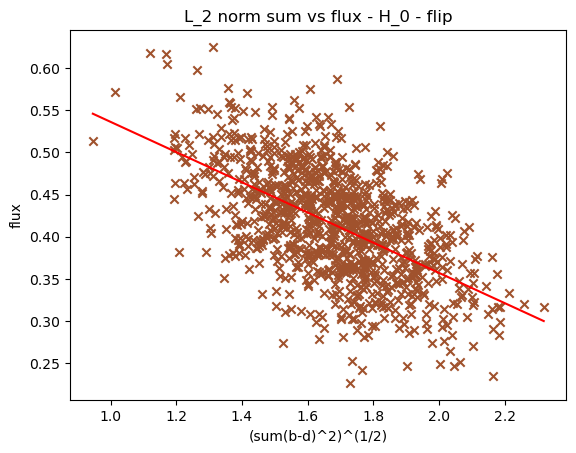

In [15]:
# L2 norm flip H0
pers1diff_sum_0_L2 = np.zeros(i)
for x in range(i): 
    C = PtCloudPers1[x,:,:]
    CH = C[np.where( C[:,2]== 0,)] 
    diff_vectC = CH[:,1] - CH[:,0]
    diff_vectCL2 = np.square(diff_vectC)
    diff_sumCL2squared = np.sum(diff_vectC)
    diff_sumCL2 = np.sqrt(diff_sumCL2squared)
    pers1diff_sum_0_L2[x] = diff_sumCL2
_ = plt.scatter(pers1diff_sum_0_L2,ft, marker='x',color='sienna')
_ = plt.title('L_2 norm sum vs flux - H_0 - flip')
_ = plt.xlabel('(sum(b-d)^2)^(1/2)')
_ = plt.ylabel('flux')

#linear regression using polynomial fit
c, m  = npl.polyfit(pers1diff_sum_0_L2, ft, 1)
a = min(pers1diff_sum_0_L2)
b = max(pers1diff_sum_0_L2)
r = [a,b]
_ = plt.plot([a,b], np.array(m) * r + c, 'r')
plt.show()

In [16]:
# L2 norm flip H0 -- test
pers1diff_sum_0_L2test = np.zeros(itest)
for x in range(itest): 
    C = PtCloudPers1test[x,:,:]
    CH = C[np.where( C[:,2]== 0,)] 
    diff_vectC = CH[:,1] - CH[:,0]
    diff_vectCL2 = np.square(diff_vectC)
    diff_sumCL2squared = np.sum(diff_vectC)
    diff_sumCL2 = np.sqrt(diff_sumCL2squared)
    pers1diff_sum_0_L2test[x] = diff_sumCL2

In [17]:
ytest = LR().fit(pers1diff_sum_0_L2.reshape(-1,1),np.array(ft)).predict(pers1diff_sum_0_L2test.reshape(-1,1))
print('nmse = ', nmse(ytest, ftest))
print('rsq = ', rsq(ytest,ftest))

nmse =  128.98829638773984
rsq =  0.35505851806130084


In [49]:
CUBEH0 = pers1diff_sum_0_L2
%store CUBEH0
CUBEH1  = pers1diff_sum_1_L2
%store CUBEH1

Stored 'CUBEH0' (ndarray)
Stored 'CUBEH1' (ndarray)


In [50]:
CUBEH0TEST = pers1diff_sum_0_L2test
%store CUBEH0TEST
CUBEH1TEST  = pers1diff_sum_1_L2test
%store CUBEH1TEST

Stored 'CUBEH0TEST' (ndarray)
Stored 'CUBEH1TEST' (ndarray)


In [18]:
# OLS flip space L2 sum H0
import statsmodels.api as sm
pers1diff_sum_0_L2plusc = sm.add_constant(pers1diff_sum_0_L2)
mod = sm.OLS(ft, pers1diff_sum_0_L2plusc)
res = mod.fit()
print(res.summary())
print(res.params)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.325
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     479.6
Date:                Sat, 15 Apr 2023   Prob (F-statistic):           4.04e-87
Time:                        16:19:55   Log-Likelihood:                 1510.0
No. Observations:                1000   AIC:                            -3016.
Df Residuals:                     998   BIC:                            -3006.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7148      0.014     51.937      0.0

1000


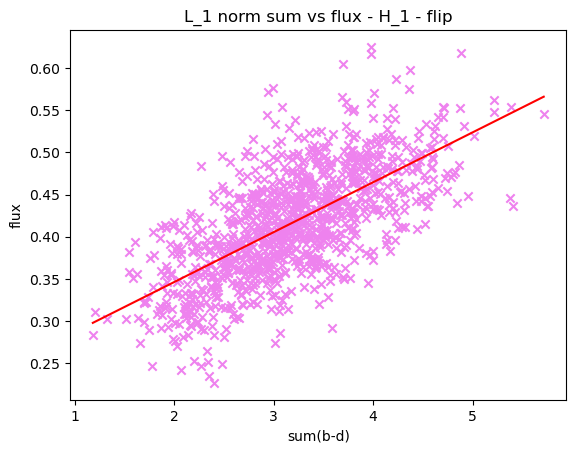

In [19]:
# sum(p-q) vs flux
import numpy.polynomial.polynomial as npl
i = PtCloudPers1.shape[0]
print(i)
pers1diff_sum_1 = np.zeros(i)
for j in range(i): 
    C = PtCloudPers1[j,:,:]
    CH = C[np.where( C[:,2]== 1,)] 
    diff_vectC = CH[:,1] - CH[:,0]
    diff_sumC = np.sum(diff_vectC)
    pers1diff_sum_1[j] = diff_sumC
_ = plt.scatter(pers1diff_sum_1,ft, marker='x',color='violet')
_ = plt.title('L_1 norm sum vs flux - H_1 - flip')
_ = plt.xlabel('sum(b-d)')
_ = plt.ylabel('flux')

#linear regression using polynomial fit
c, m  = npl.polyfit(pers1diff_sum_1, ft, 1)
r = [min(pers1diff_sum_1),max(pers1diff_sum_1)]
_ = plt.plot([min(pers1diff_sum_1),max(pers1diff_sum_1)], np.array(m) * r + c, 'r')
plt.show()

In [20]:
# sum(p-q) vs flux  --test
pers1diff_sum_1test = np.zeros(itest)
for j in range(itest): 
    C = PtCloudPers1test[j,:,:]
    CH = C[np.where( C[:,2]== 1,)] 
    diff_vectC = CH[:,1] - CH[:,0]
    diff_sumC = np.sum(diff_vectC)
    pers1diff_sum_1test[j] = diff_sumC

In [21]:
# test nmse and rsq flip L1 H1
ytest = LR().fit(pers1diff_sum_1.reshape(-1,1),np.array(ft)).predict(pers1diff_sum_1test.reshape(-1,1))
print('results on the training set linear regression, L1 sum, H1, flip method')
print('nmse = ', nmse(ytest, ftest))
print('rsq = ', rsq(ytest,ftest))

results on the training set linear regression, L1 sum, H1, flip method
nmse =  91.14058740638664
rsq =  0.5442970629680668


In [22]:
# OLS flip space L1 sum H1
import statsmodels.api as sm
pers1diff_sum_1plusc = sm.add_constant(pers1diff_sum_1)
mod = sm.OLS(ft, pers1diff_sum_1plusc)
res = mod.fit()
print(res.summary())
print(res.params)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     804.2
Date:                Sat, 15 Apr 2023   Prob (F-statistic):          3.12e-130
Time:                        16:20:53   Log-Likelihood:                 1609.3
No. Observations:                1000   AIC:                            -3215.
Df Residuals:                     998   BIC:                            -3205.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2285      0.007     33.714      0.0

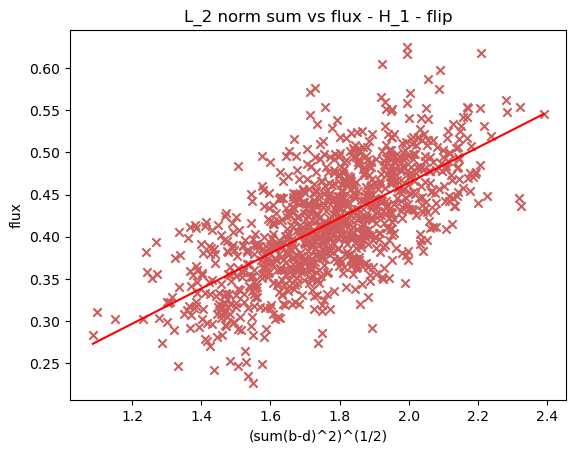

In [24]:
# L2 norm flip H1
pers1diff_sum_1_L2 = np.zeros(i)
for x in range(i): 
    C = PtCloudPers1[x,:,:]
    CH = C[np.where( C[:,2]== 1,)] 
    diff_vectC = CH[:,1] - CH[:,0]
    diff_vectCL2 = np.square(diff_vectC)
    diff_sumCL2squared = np.sum(diff_vectC)
    diff_sumCL2 = np.sqrt(diff_sumCL2squared)
    pers1diff_sum_1_L2[x] = diff_sumCL2
_ = plt.scatter(pers1diff_sum_1_L2,ft, marker='x',color='indianred')
_ = plt.title('L_2 norm sum vs flux - H_1 - flip')
_ = plt.xlabel('(sum(b-d)^2)^(1/2)')
_ = plt.ylabel('flux')

#linear regression using polynomial fit
c, m  = npl.polyfit(pers1diff_sum_1_L2, ft, 1)
a = min(pers1diff_sum_1_L2)
b = max(pers1diff_sum_1_L2)
r = [a,b]
_ = plt.plot([a,b], np.array(m) * r + c, 'r')
plt.show()

In [25]:
# L2 norm flip H1 -- test
pers1diff_sum_1_L2test = np.zeros(itest)
for x in range(itest): 
    C = PtCloudPers1test[x,:,:]
    CH = C[np.where( C[:,2]== 1,)] 
    diff_vectC = CH[:,1] - CH[:,0]
    diff_vectCL2 = np.square(diff_vectC)
    diff_sumCL2squared = np.sum(diff_vectC)
    diff_sumCL2 = np.sqrt(diff_sumCL2squared)
    pers1diff_sum_1_L2test[x] = diff_sumCL2

In [26]:
# test nmse and rsq flip L2 H1
ytest = LR().fit(pers1diff_sum_1_L2.reshape(-1,1),np.array(ft)).predict(pers1diff_sum_1_L2test.reshape(-1,1))
print('results on the training set linear regression, L2 sum, H1, flip method')
print('nmse = ', nmse(ytest, ftest))
print('rsq = ', rsq(ytest,ftest))

results on the training set linear regression, L2 sum, H1, flip method
nmse =  92.2195155696194
rsq =  0.538902422151903


In [27]:
# OLS flip space L2 sum H1
import statsmodels.api as sm
pers1diff_sum_1_L2plusc = sm.add_constant(pers1diff_sum_1_L2)
mod = sm.OLS(ft, pers1diff_sum_1_L2plusc)
res = mod.fit()
print(res.summary())
print(res.params)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     814.1
Date:                Sat, 15 Apr 2023   Prob (F-statistic):          2.02e-131
Time:                        16:21:25   Log-Likelihood:                 1612.0
No. Observations:                1000   AIC:                            -3220.
Df Residuals:                     998   BIC:                            -3210.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0469      0.013      3.600      0.0

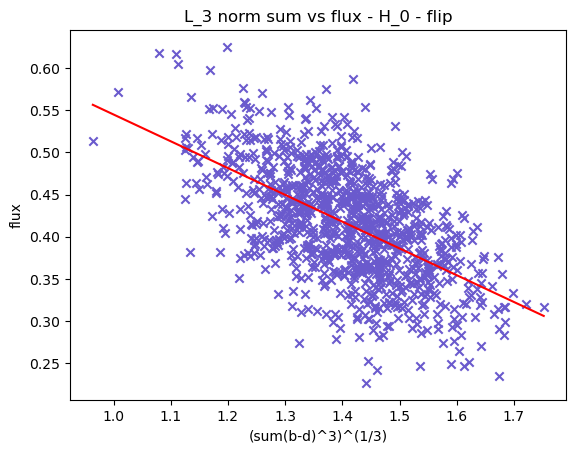

In [28]:
# L3 norm flip H0
pers1diff_sum_0_L3 = np.zeros(i)
for x in range(i): 
    C = PtCloudPers1[x,:,:]
    CH = C[np.where( C[:,2]== 0,)] 
    diff_vectC = CH[:,1] - CH[:,0]
    diff_vectCpower = np.power(diff_vectC,3)
    diff_sumCpower = np.sum(diff_vectC)
    diff_sumCroot = np.power(diff_sumCpower,1/3)
    pers1diff_sum_0_L3[x] = diff_sumCroot

# test set
pers1diff_sum_0_L3test = np.zeros(itest)
for x in range(itest): 
    C = PtCloudPers1test[x,:,:]
    CH = C[np.where( C[:,2]== 0,)] 
    diff_vectC = CH[:,1] - CH[:,0]
    diff_vectCpower = np.power(diff_vectC,3)
    diff_sumCpower = np.sum(diff_vectC)
    diff_sumCroot = np.power(diff_sumCpower,1/3)
    pers1diff_sum_0_L3test[x] = diff_sumCroot

_ = plt.scatter(pers1diff_sum_0_L3,ft, marker='x',color='slateblue')
_ = plt.title('L_3 norm sum vs flux - H_0 - flip')
_ = plt.xlabel('(sum(b-d)^3)^(1/3)')
_ = plt.ylabel('flux')
#linear regression using polynomial fit
c, m  = npl.polyfit(pers1diff_sum_0_L3, ft, 1)
a = min(pers1diff_sum_0_L3)
b = max(pers1diff_sum_0_L3)
r = [a,b]
_ = plt.plot([a,b], np.array(m) * r + c, 'r')
plt.show()

In [29]:
# test nmse and rsq flip L3 H0
ytest = LR().fit(pers1diff_sum_0_L3.reshape(-1,1),np.array(ft)).predict(pers1diff_sum_0_L3test.reshape(-1,1))
print('results on the training set linear regression, L1 sum, H1, flip method')
print('nmse = ', nmse(ytest, ftest))
print('rsq = ', rsq(ytest,ftest))

results on the training set linear regression, L1 sum, H1, flip method
nmse =  128.45339793046233
rsq =  0.35773301034768834


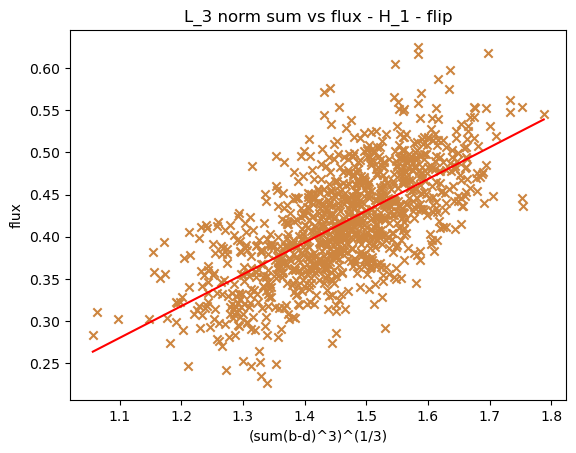

In [30]:
# L3 norm flip H1
pers1diff_sum_1_L3 = np.zeros(i)
for x in range(i): 
    C = PtCloudPers1[x,:,:]
    CH = C[np.where( C[:,2]== 1,)] 
    diff_vectC = CH[:,1] - CH[:,0]
    diff_vectCpower = np.power(diff_vectC,3)
    diff_sumCpower = np.sum(diff_vectC)
    diff_sumCroot = np.power(diff_sumCpower,1/3)
    pers1diff_sum_1_L3[x] = diff_sumCroot

# test set
pers1diff_sum_1_L3test = np.zeros(itest)
for x in range(itest): 
    C = PtCloudPers1test[x,:,:]
    CH = C[np.where( C[:,2]== 1,)] 
    diff_vectC = CH[:,1] - CH[:,0]
    diff_vectCpower = np.power(diff_vectC,3)
    diff_sumCpower = np.sum(diff_vectC)
    diff_sumCroot = np.power(diff_sumCpower,1/3)
    pers1diff_sum_1_L3test[x] = diff_sumCroot

_ = plt.scatter(pers1diff_sum_1_L3,ft, marker='x',color='peru')
_ = plt.title('L_3 norm sum vs flux - H_1 - flip')
_ = plt.xlabel('(sum(b-d)^3)^(1/3)')
_ = plt.ylabel('flux')
#linear regression using polynomial fit
c, m  = npl.polyfit(pers1diff_sum_1_L3, ft, 1)
a = min(pers1diff_sum_1_L3)
b = max(pers1diff_sum_1_L3)
r = [a,b]
_ = plt.plot([a,b], np.array(m) * r + c, 'r')
plt.show()

In [31]:
# test nmse and rsq flip L3 H1
ytest = LR().fit(pers1diff_sum_1_L3.reshape(-1,1),np.array(ft)).predict(pers1diff_sum_1_L3test.reshape(-1,1))
print('results on the training set linear regression, L3 sum, H1, flip method')
print('nmse = ', nmse(ytest, ftest))
print('rsq = ', rsq(ytest,ftest))

results on the training set linear regression, L3 sum, H1, flip method
nmse =  92.87484614951885
rsq =  0.5356257692524057


In [48]:
# creating a lower resolution image to allow for greater no. of tests
prtqtr = list()
Y = int(y/2)
X = int(x/2)
f=0
g=0
for m in range(n):
    prtqtrdummy = np.zeros([Y,X])
    for f in range(Y):
        for g in range(X):
            prtqtrdummy[f,g] = (1/4)*(prt[m,2*f,2*g]+prt[m,2*f+1,2*g]+prt[m,2*f,2*g+1]+prt[m,2*f+1,2*g+1])
    prtqtr.append(prtqtrdummy)


IndexError: index 50 is out of bounds for axis 2 with size 50

NameError: name 'prtqtr' is not defined

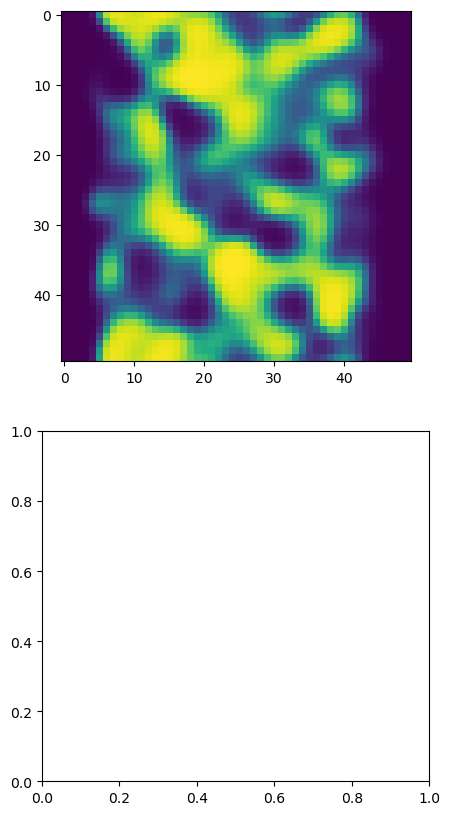

In [51]:
# comparison smaller array to bigger array
inum = 19
train = prt[inum]
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(5,10), gridspec_kw={'height_ratios': [1,1]})
ax1.imshow(train)
train = prtqtr[inum]
ax2.imshow(train)

In [32]:
# test nmse and rsq flip L1 H0 and H1
pers1diff_sum_01 = np.array([pers1diff_sum_0,pers1diff_sum_1]).T
pers1diff_sum_01test = np.array([pers1diff_sum_0test,pers1diff_sum_1test]).T
ytest = LR().fit(pers1diff_sum_01,np.array(ft)).predict(pers1diff_sum_01test)
print('results on the training set linear regression, L1 sum, H0 and H1, flip method')
print('nmse = ', nmse(ytest, ftest))
print('rsq = ', rsq(ytest,ftest))

results on the training set linear regression, L1 sum, H0 and H1, flip method
nmse =  63.88657637775178
rsq =  0.680567118111241


In [33]:
#statsmodel flip space OLS L1 H0 and H1
import statsmodels.api as sm
pers1diff_sum_01 = np.array([pers1diff_sum_0,pers1diff_sum_1]).T
pers1diff_sum_01plusc = sm.add_constant(pers1diff_sum_01)
mod01 = sm.OLS(ft, pers1diff_sum_01plusc)
res01 = mod01.fit()
print(res01.summary())
print(res01.params)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     757.1
Date:                Sat, 15 Apr 2023   Prob (F-statistic):          1.03e-200
Time:                        16:22:40   Log-Likelihood:                 1775.7
No. Observations:                1000   AIC:                            -3545.
Df Residuals:                     997   BIC:                            -3531.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3703      0.009     40.385      0.0

In [34]:
# test nmse and rsq flip L2 H0 and H1
pers1diff_sum_01_L2 = np.array([pers1diff_sum_0_L2,pers1diff_sum_1_L2]).T
pers1diff_sum_01_L2test = np.array([pers1diff_sum_0_L2test,pers1diff_sum_1_L2test]).T
ytest = LR().fit(pers1diff_sum_01_L2,np.array(ft)).predict(pers1diff_sum_01_L2test)
print('results on the training set linear regression, L2 sum, H0 and H1, flip method')
print('nmse = ', nmse(ytest, ftest))
print('rsq = ', rsq(ytest,ftest))

results on the training set linear regression, L2 sum, H0 and H1, flip method
nmse =  63.9624367469234
rsq =  0.6801878162653829


In [35]:
#statsmodel flip space OLS L2 H0 and H1
import statsmodels.api as sm
pers1diff_sum_01_L2 = np.array([pers1diff_sum_0_L2,pers1diff_sum_1_L2]).T
pers1diff_sum_01_L2plusc = sm.add_constant(pers1diff_sum_01_L2)
mod01 = sm.OLS(ft, pers1diff_sum_01_L2plusc)
res01 = mod01.fit()
print(res01.summary())
print(res01.params)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     780.7
Date:                Sat, 15 Apr 2023   Prob (F-statistic):          9.32e-205
Time:                        16:22:56   Log-Likelihood:                 1785.0
No. Observations:                1000   AIC:                            -3564.
Df Residuals:                     997   BIC:                            -3549.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3289      0.018     18.589      0.0

In [39]:
# try adding measure -- flip L2 norm and msr
msr = np.sum(np.sum(prt, axis=-1), axis=-1)
msrtest = np.sum(np.sum(prtest, axis=-1), axis=-1)
msr.shape
pers1diff_sum_0.shape

(1000,)

In [40]:

pers1diff_sum_1_L2_addmsr = np.array([pers1diff_sum_1_L2,msr]).T
pers1diff_sum_1_L2_addmsrtest = np.array([pers1diff_sum_1_L2test,msrtest]).T
ytest = LR().fit(pers1diff_sum_1_L2_addmsr,np.array(ft)).predict(pers1diff_sum_1_L2_addmsrtest)
print('results on the training set linear regression, L2 sum H1 and msr, flip method')
print('nmse = ', nmse(ytest, ftest))
print('rsq = ', rsq(ytest,ftest))

results on the training set linear regression, L2 sum H1 and msr, flip method
nmse =  23.175704787662074
rsq =  0.8841214760616897


In [47]:

pers1diff_sum_0_L2_addmsr = np.array([pers1diff_sum_0_L2,msr]).T
pers1diff_sum_0_L2_addmsrtest = np.array([pers1diff_sum_0_L2test,msrtest]).T
ytest = LR().fit(pers1diff_sum_0_L2_addmsr,np.array(ft)).predict(pers1diff_sum_0_L2_addmsrtest)
print('results on the training set linear regression, L2 sum H1 and msr, flip method')
print('nmse = ', nmse(ytest, ftest))
print('rsq = ', rsq(ytest,ftest))

results on the training set linear regression, L2 sum H1 and msr, flip method
nmse =  26.665724380161464
rsq =  0.8666713780991927


In [41]:
CUBICAL = PtCloudPers1
%store CUBICAL

Stored 'CUBICAL' (ndarray)


In [101]:
from gtda.homology import VietorisRipsPersistence
VR = VietorisRipsPersistence()
PtCloudPers2 = VR.fit_transform(xypts2)
VR.plot(PtCloudPers2,0)

1000


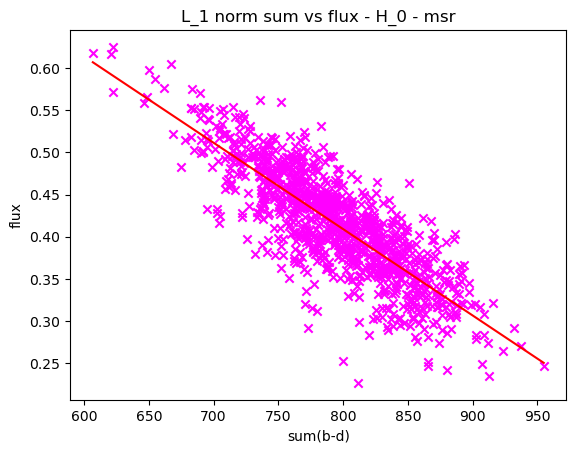

In [198]:
# sum(p-q) vs flux
import numpy.polynomial.polynomial as npl
i = PtCloudPers2.shape[0]
print(i)
Pers2_diff_sum_0 = np.zeros(i)
for j in range(i): 
    C = PtCloudPers2[j,:,:]
    CH = C[np.where( C[:,2]== 0,)] 
    diff_vectC = CH[:,1] - CH[:,0]
    diff_sumC = np.sum(diff_vectC)
    Pers2_diff_sum_0[j] = diff_sumC
_ = plt.scatter(Pers2_diff_sum_0,ft, marker='x',color='magenta')
_ = plt.title('L_1 norm sum vs flux - H_0 - msr')
_ = plt.xlabel('sum(b-d)')
_ = plt.ylabel('flux')

#linear regression using polynomial fit
c, m  = npl.polyfit(Pers2_diff_sum_0, ft, 1)
r = [min(Pers2_diff_sum_0),max(Pers2_diff_sum_0)]
_ = plt.plot([min(Pers2_diff_sum_0),max(Pers2_diff_sum_0)], np.array(m) * r + c, 'r')
plt.show()

1000


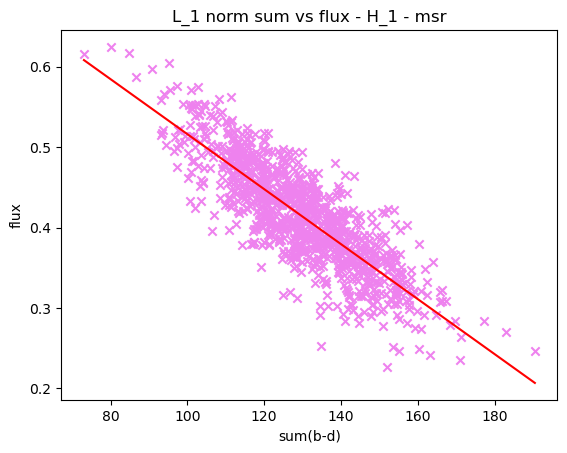

In [199]:
# sum(p-q) vs flux
import numpy.polynomial.polynomial as npl
i = PtCloudPers2.shape[0]
print(i)
Pers2_diff_sum_1 = np.zeros(i)
for j in range(i): 
    C = PtCloudPers2[j,:,:]
    CH = C[np.where( C[:,2]== 1,)] 
    diff_vectC = CH[:,1] - CH[:,0]
    diff_sumC = np.sum(diff_vectC)
    Pers2_diff_sum_1[j] = diff_sumC
_ = plt.scatter(Pers2_diff_sum_1,ft, marker='x',color='violet')
_ = plt.title('L_1 norm sum vs flux - H_1 - msr')
_ = plt.xlabel('sum(b-d)')
_ = plt.ylabel('flux')

#linear regression using polynomial fit
c, m  = npl.polyfit(Pers2_diff_sum_1, ft, 1)
r = [min(Pers2_diff_sum_1),max(Pers2_diff_sum_1)]
_ = plt.plot([min(Pers2_diff_sum_1),max(Pers2_diff_sum_1)], np.array(m) * r + c, 'r')
plt.show()

In [200]:
#Persistence diagrams flips
from gtda.diagrams import PersistenceLandscape
PLless = PersistenceLandscape(n_layers=10,n_bins=10)
xflip= PLless.fit_transform(PtCloudPers1)

In [201]:
PLless.plot(xflip,340)

In [202]:
#linear regression of all layers flip
a,b,c = xflip.shape
print(a,b,c)
xflipall = np.reshape(xflip,[a,b*c,-1])[:,:,0]
xflipallc = sm.add_constant(xflipall)
flippersmodelall = sm.OLS(ft,xflipallc)
flippersresultsall = flippersmodelall.fit()
print(flippersresultsall.summary())

1000 20 10
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.368
Method:                 Least Squares   F-statistic:                     7.928
Date:                Tue, 21 Feb 2023   Prob (F-statistic):           2.25e-64
Time:                        16:12:46   Log-Likelihood:                 1587.2
No. Observations:                1000   AIC:                            -3004.
Df Residuals:                     915   BIC:                            -2587.
Df Model:                          84                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5689      0.767      0.7

In [203]:
#linear regression first layer flip
PL = PersistenceLandscape(n_layers=2,n_bins=100)
xflipbins = PL.fit_transform(PtCloudPers1)
PL.plot(xflipbins,340)

In [204]:
#linear regression of first layer of H0 and H1 flip

xflipbins01  = np.concatenate((xflipbins[:,0,:],xflipbins[:,2,:]), axis=1)
flippersmodel01 = sm.OLS(ft,xflipbins01)
flippersresults01 = flippersmodel01.fit()
print(flippersresults01.summary())
#note that adding a constant is pointless really as the first and last values in each vector is always 0

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     4.137
Date:                Tue, 21 Feb 2023   Prob (F-statistic):           2.19e-32
Time:                        16:15:07   Log-Likelihood:                 1517.0
No. Observations:                1000   AIC:                            -2816.
Df Residuals:                     891   BIC:                            -2281.
Df Model:                         108                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.872e-13   1.74e-13      1.075      0.2

In [154]:
#Persistence diagrams from our measure space method
from gtda.diagrams import PersistenceLandscape
xmsr= PLless.fit_transform(PtCloudPers2)

In [158]:
PLless.plot(xmsr,340)

In [162]:
#linear regression of all layers msr
a,b,c = xmsr.shape
print(a,b,c)
xmsrall = np.reshape(xmsr,[a,b*c,-1])[:,:,0]
xmsrallc = sm.add_constant(xmsrall)
msrpersmodelall = sm.OLS(ft,xmsrallc)
msrpersresultsall = msrpersmodelall.fit()
print(msrpersresultsall.summary())

1000 20 10
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     9.690
Date:                Tue, 21 Feb 2023   Prob (F-statistic):           1.68e-76
Time:                        11:59:54   Log-Likelihood:                 1613.4
No. Observations:                1000   AIC:                            -3069.
Df Residuals:                     921   BIC:                            -2681.
Df Model:                          78                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.028e-16   5.88e-16      0.8

In [159]:
#linear regression first layer
PL = PersistenceLandscape(n_layers=2,n_bins=100)
xmsrbins = PL.fit_transform(PtCloudPers2)
PL.plot(xmsrbins,340)

In [161]:
#linear regression of first layer of H0 and H1 msr

xmsrbins01  = np.concatenate((xmsrbins[:,0,:],xmsrbins[:,2,:]), axis=1)
msrpersmodel01 = sm.OLS(ft,xmsrbins01)
msrpersresults01 = msrpersmodel01.fit()
print(msrpersresults01.summary())
#note that adding a constant is pointless really as the first and last values in each vector is always 0

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.258
Method:                 Least Squares   F-statistic:                     4.337
Date:                Mon, 20 Feb 2023   Prob (F-statistic):           6.62e-34
Time:                        12:48:31   Log-Likelihood:                 1517.8
No. Observations:                1000   AIC:                            -2826.
Df Residuals:                     895   BIC:                            -2310.
Df Model:                         104                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.908e-14   1.39e-13      0.642      0.5

In [43]:
CUBEH0TEST = pers1diff_sum_0_L2test
%store CUBEH0TEST

Stored 'CUBEH0TEST' (ndarray)


In [44]:
MEANTEST = msrtest
%store MEANTEST

Stored 'MEANTEST' (ndarray)


In [45]:

pers1diff_sum_1_L2_addmsr = np.array([pers1diff_sum_1_L2,msr]).T
pers1diff_sum_1_L2_addmsrtest = np.array([pers1diff_sum_1_L2test,msrtest]).T
ytest = LR().fit(pers1diff_sum_1_L2_addmsr,np.array(ft)).predict(pers1diff_sum_1_L2_addmsrtest)
print('results on the training set linear regression, L2 sum H1 and msr, flip method')
print('nmse = ', nmse(ytest, ftest))
print('rsq = ', rsq(ytest,ftest))

results on the training set linear regression, L2 sum H1 and msr, flip method
nmse =  23.175704787662074
rsq =  0.8841214760616897


In [59]:
i = PtCloudPers1.shape[0]
bespokev = np.zeros(i)
for j in range(i): 
    C = PtCloudPers1[j,:,:]
    CH = C[np.where( C[:,2]== 0,)] 
    CHH = CH[np.where(CH[:,0] == 0)]    
    bespokev[j] = CHH.sum()

itest = PtCloudPers1test.shape[0]
bespokevtest = np.zeros(itest)
for j in range(itest): 
    C = PtCloudPers1test[j,:,:]
    CH = C[np.where( C[:,2]== 0,)] 
    CHH = CH[np.where(CH[:,0] == 0)]    
    bespokevtest[j] = CHH.sum()


In [62]:
ytest = LR().fit(bespokev.reshape(-1,1),np.array(ft)).predict(bespokevtest.reshape(-1,1))
print('results on the training set linear regression, L2 sum H1 and msr, flip method')
print('nmse = ', nmse(ytest, ftest))
print('rsq = ', rsq(ytest,ftest))

results on the training set linear regression, L2 sum H1 and msr, flip method
nmse =  118.45456417285044
rsq =  0.40772717913574774


In [60]:

bespokevmsr = np.array([bespokev,msr]).T
bespokevtestmsr = np.array([bespokevtest,msrtest]).T
ytest = LR().fit(bespokevmsr,np.array(ft)).predict(bespokevtestmsr)
print('results on the training set linear regression, L2 sum H1 and msr, flip method')
print('nmse = ', nmse(ytest, ftest))
print('rsq = ', rsq(ytest,ftest))

results on the training set linear regression, L2 sum H1 and msr, flip method
nmse =  26.46363665547316
rsq =  0.8676818167226342


In [64]:
BESPOKECUBEH0 = bespokev
%store BESPOKECUBEH0
BESPOKECUBEH0TEST = bespokevtest
%store BESPOKECUBEH0TEST

Stored 'BESPOKECUBEH0' (ndarray)
Stored 'BESPOKECUBEH0TEST' (ndarray)


In [66]:
%store -r MEAN
%store -r MEANTEST

In [68]:
dummy = np.array([CUBEH1,MEAN]).T
dummytest = np.array([CUBEH1TEST ,MEANTEST]).T
ytest = LR().fit(dummy,np.array(ft)).predict(dummytest)
print('results on the training set linear regression, L2 sum H1 and msr, flip method')
print('nmse = ', nmse(ytest, ftest))
print('rsq = ', rsq(ytest,ftest))

results on the training set linear regression, L2 sum H1 and msr, flip method
nmse =  23.175704787662074
rsq =  0.8841214760616897


In [67]:
dummy = np.array([CUBEH1,MEAN, BESPOKECUBEH0]).T
dummytest = np.array([CUBEH1TEST ,MEANTEST,BESPOKECUBEH0TEST]).T
ytest = LR().fit(dummy,np.array(ft)).predict(dummytest)
print('results on the training set linear regression, L2 sum H1 and msr, flip method')
print('nmse = ', nmse(ytest, ftest))
print('rsq = ', rsq(ytest,ftest))

results on the training set linear regression, L2 sum H1 and msr, flip method
nmse =  22.368823921008506
rsq =  0.8881558803949575


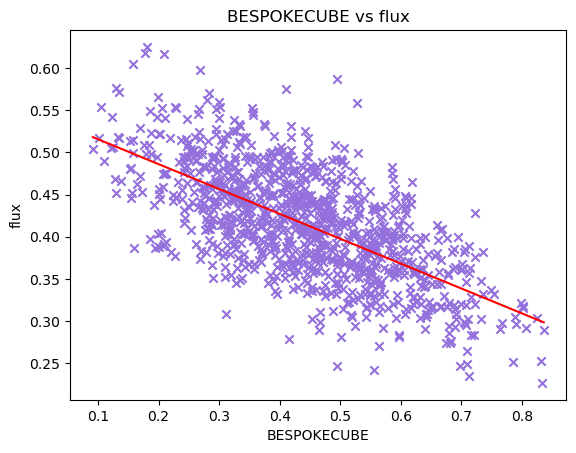

In [74]:
dummy = bespokev
_ = plt.scatter(dummy,ft, marker='x',color='mediumpurple')
_ = plt.title('BESPOKECUBE vs flux')
_ = plt.xlabel('BESPOKECUBE')
_ = plt.ylabel('flux')
#linear regression using polynomial fit
c, m  = npl.polyfit(dummy, ft, 1)
a = min(dummy)
b = max(dummy)
r = [a,b]
_ = plt.plot([a,b], np.array(m) * r + c, 'r')
plt.show()

In [71]:
bespokev[0]

0.3337535742784661

In [73]:
PtCloudPers1[0][np.where(PtCloudPers1[0][:,2] == 1)]

array([[3.14536137e-01, 8.79562509e-01, 1.00000000e+00],
       [5.00932373e-01, 9.97892425e-01, 1.00000000e+00],
       [3.60203128e-01, 7.96957729e-01, 1.00000000e+00],
       [6.09168875e-01, 9.90388779e-01, 1.00000000e+00],
       [5.08183565e-01, 8.36740324e-01, 1.00000000e+00],
       [5.80435610e-01, 8.99798632e-01, 1.00000000e+00],
       [3.70128777e-01, 6.21429721e-01, 1.00000000e+00],
       [7.34955019e-01, 9.84749329e-01, 1.00000000e+00],
       [8.00165098e-01, 9.54405328e-01, 1.00000000e+00],
       [8.25702873e-01, 9.78961468e-01, 1.00000000e+00],
       [8.10486319e-01, 9.22417710e-01, 1.00000000e+00],
       [4.91399334e-01, 6.00946676e-01, 1.00000000e+00],
       [7.86055170e-01, 8.82963104e-01, 1.00000000e+00],
       [4.88164113e-01, 5.68339714e-01, 1.00000000e+00],
       [9.01760848e-01, 9.56538054e-01, 1.00000000e+00],
       [9.45088519e-01, 9.74790400e-01, 1.00000000e+00],
       [9.15004131e-01, 9.43153924e-01, 1.00000000e+00],
       [5.28817794e-01, 5.52398

In [81]:
# bespoke 2 H0
bespoke2H0 = np.zeros(n)
for j in range(n): 
    C = PtCloudPers1[j,:,:]
    CH = C[np.where( C[:,2]== 0,)] 
    diff_vectC = CH[:,1] - CH[:,0]
    diff_sumC = np.max(diff_vectC)
    bespoke2H0[j] = diff_sumC

bespoke2H0test = np.zeros(ntest)
for j in range(ntest): 
    C = PtCloudPers1test[j,:,:]
    CH = C[np.where( C[:,2]== 0,)] 
    diff_vectC = CH[:,1] - CH[:,0]
    diff_sumC = np.max(diff_vectC)
    bespoke2H0test[j] = diff_sumC


In [86]:
# bespoke 2 H1
bespoke2H1 = np.zeros(n)
for j in range(n): 
    C = PtCloudPers1[j,:,:]
    CH = C[np.where( C[:,2]== 0,)] 
    diff_vectC = CH[:,1] - CH[:,0]
    diff_sumC = np.max(diff_vectC)
    bespoke2H1[j] = diff_sumC

bespoke2H1test = np.zeros(ntest)
for j in range(ntest): 
    C = PtCloudPers1test[j,:,:]
    CH = C[np.where( C[:,2]== 0,)] 
    diff_vectC = CH[:,1] - CH[:,0]
    diff_sumC = np.max(diff_vectC)
    bespoke2H1test[j] = diff_sumC

In [83]:
ytest = LR().fit(bespoke2H0.reshape(-1,1),np.array(ft)).predict(bespoke2H0test.reshape(-1,1))
print('results on the training set linear regression, L2 sum H1 and msr, flip method')
print('nmse = ', nmse(ytest, ftest))
print('rsq = ', rsq(ytest,ftest))

results on the training set linear regression, L2 sum H1 and msr, flip method
nmse =  135.29449559883344
rsq =  0.3235275220058328


In [87]:
ytest = LR().fit(bespoke2H1.reshape(-1,1),np.array(ft)).predict(bespoke2H1test.reshape(-1,1))
print('results on the training set linear regression, L2 sum H1 and msr, flip method')
print('nmse = ', nmse(ytest, ftest))
print('rsq = ', rsq(ytest,ftest))

results on the training set linear regression, L2 sum H1 and msr, flip method
nmse =  135.29449559883344
rsq =  0.3235275220058328


In [89]:
dummy = np.array([bespoke2H0,MEAN]).T
dummytest = np.array([bespoke2H0test ,MEANTEST]).T
ytest = LR().fit(dummy,np.array(ft)).predict(dummytest)
print('results on the training set linear regression, L2 sum H1 and msr, flip method')
print('nmse = ', nmse(ytest, ftest))
print('rsq = ', rsq(ytest,ftest))

results on the training set linear regression, L2 sum H1 and msr, flip method
nmse =  28.149299837523273
rsq =  0.8592535008123836


In [90]:
dummy = np.array([bespoke2H1,MEAN]).T
dummytest = np.array([bespoke2H1test ,MEANTEST]).T
ytest = LR().fit(dummy,np.array(ft)).predict(dummytest)
print('results on the training set linear regression, L2 sum H1 and msr, flip method')
print('nmse = ', nmse(ytest, ftest))
print('rsq = ', rsq(ytest,ftest))

results on the training set linear regression, L2 sum H1 and msr, flip method
nmse =  28.149299837523273
rsq =  0.8592535008123836


In [80]:
dummy = np.array([bespoke2H0, bespokev, MEAN]).T
dummytest = np.array([bespoke2H0test, bespokevtest,MEANTEST]).T
ytest = LR().fit(dummy,np.array(ft)).predict(dummytest)
print('results on the training set linear regression, L2 sum H1 and msr, flip method')
print('nmse = ', nmse(ytest, ftest))
print('rsq = ', rsq(ytest,ftest))

results on the training set linear regression, L2 sum H1 and msr, flip method
nmse =  26.565360774821244
rsq =  0.8671731961258938


In [85]:
dummy = np.array([bespoke2H0, bespokev, CUBEH0, MEAN]).T
dummytest = np.array([bespoke2H0test, bespokevtest, CUBEH0TEST, MEANTEST]).T
ytest = LR().fit(dummy,np.array(ft)).predict(dummytest)
print('results on the training set linear regression, L2 sum H1 and msr, flip method')
print('nmse = ', nmse(ytest, ftest))
print('rsq = ', rsq(ytest,ftest))

results on the training set linear regression, L2 sum H1 and msr, flip method
nmse =  25.022911902254158
rsq =  0.8748854404887292


In [93]:
s=0

[[0.00000000e+00 4.69332678e-01 0.00000000e+00]
 [1.37207506e-02 3.83060324e-01 0.00000000e+00]
 [9.20639767e-02 4.08025259e-01 0.00000000e+00]
 [1.98633839e-02 2.86051754e-01 0.00000000e+00]
 [1.42357939e-02 2.72824918e-01 0.00000000e+00]
 [4.58559584e-02 2.87524449e-01 0.00000000e+00]
 [6.62140763e-02 2.93893761e-01 0.00000000e+00]
 [1.07389605e-01 2.77235869e-01 0.00000000e+00]
 [2.62311076e-02 1.65649086e-01 0.00000000e+00]
 [1.75872277e-01 3.06609833e-01 0.00000000e+00]
 [3.21897469e-01 4.08644962e-01 0.00000000e+00]
 [2.03411620e-01 2.78173360e-01 0.00000000e+00]
 [3.58625830e-02 9.22861608e-02 0.00000000e+00]
 [2.24029932e-01 2.69025167e-01 0.00000000e+00]
 [5.23903962e-02 9.59894081e-02 0.00000000e+00]
 [1.24664855e-01 1.52300048e-01 0.00000000e+00]
 [2.42540248e-02 4.61528679e-02 0.00000000e+00]
 [8.16499651e-02 9.79803976e-02 0.00000000e+00]
 [2.57479824e-01 2.72124476e-01 0.00000000e+00]
 [8.38160709e-02 8.99393280e-02 0.00000000e+00]
 [1.73149931e-02 2.21465431e-02 0.000000

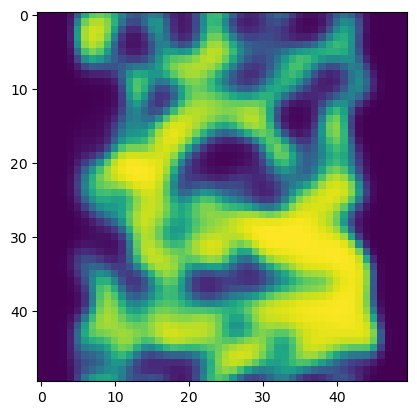

In [97]:
plt.imshow(prt[s])
s=s+1
print(PtCloudPers1[s], ft[s])